In [2]:
# add snmi to path
import sys
sys.path.append('../../')

## Dataset

In [3]:
import matplotlib.pyplot as plt
import glob


from torch.utils.data.dataloader import DataLoader
from snmi.core import BaseDataset
from snmi.utils import augmentation_methods as A, process_methods as P

# hyper-parameters
train_batch_size = 10
eval_batch_size = 10

In [2]:
# load data
data_path = './data/skin'
data_list = glob.glob(data_path + '/*.jpg')
train = data_list[:60]
valid = data_list[60:70]
test = data_list[70:]
print(f'train: {len(train)}, valid: {len(valid)}, test: {len(test)}')

train: 60, valid: 10, test: 30


'.jpg': (3, 128, 128)
'_segmentation.png': (2, 128, 128)


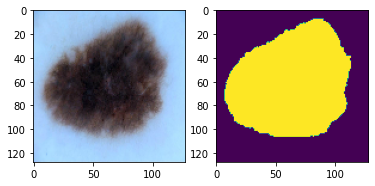

In [3]:
# Data keys: (key for data_dict and) suffix for image and label (the difference between image path and label path) for data loading
img_suffix = '.jpg'
lab_suffix = '_segmentation.png'

# set pre-process functions for image and label, #TODO: more method see utils/process_methods
# functions in torchvision.transforms also works here, see https://pytorch.org/vision/stable/transforms.html#functional-transforms
pre = {img_suffix: [P.Resize([128,128]), 
                    P.min_max,
                    P.Transpose([2,0,1]),
        ],
        lab_suffix: [P.Resize([128,128], nearest=True),
                    P.OneHot([0,255])
        ]}
# set data augmentation method
aug = A.RandomAugmentation(img_suffix, lab_suffix)

# build pytorch dataset, see core/basic_dataset
train_set = BaseDataset(train, [img_suffix, lab_suffix], pre, aug)
valid_set = BaseDataset(valid, [img_suffix, lab_suffix], pre)

# build pytorch data loader, shuffle train set while training
trainloader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=eval_batch_size)

data_dict = train_set[0]
print('\n'.join([f'\'{k}\': {v.shape}' for (k,v) in data_dict.items()]))
plt.subplot(1, 2, 1)
plt.imshow(data_dict[img_suffix].transpose([1,2,0]))
plt.subplot(1, 2, 2)
plt.imshow(data_dict[lab_suffix][1])

## Network and Model

In [4]:
import torch

from snmi.models import SegModel
from snmi.nets.unet2D import Unet2D
from snmi.utils import loss_fuctions as LF

# hyper-parameters
learning_rate = 1e-4
dropout_rate = 0.2

In [5]:
# build 2D unet for 2 classes segmentation, the input channel is 3 since the data is rgb image 
net = Unet2D(n_classes=2, in_channels=3)

# init optimizer, adam is used here
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# {method: weight}
# set loss functions {method_1: weight_1, method_2: weight_2, ...}
loss_function = {LF.CrossEntropy(): 0.5, LF.SoftDice(): 0.5}
# init the model, #TODO: more details see modelnet/model
model = SegModel(net, optimizer, img_suffix, lab_suffix, dropout_rate=dropout_rate, loss_functions=loss_function)

In [ ]:
from snmi.models import SegModel
from snmi.nets.unet2D import Unet2D
from snmi.utils import loss_fuctions as LF

net = Unet2D(n_classes=2, in_channels=3)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# loss functions {method_1: weight_1, method_2: weight_2, ...}
loss_function = {LF.CrossEntropy(): 0.5, LF.SoftDice(): 0.5}
model = SegModel(net, optimizer, img_suffix, lab_suffix, 
                dropout_rate=dropout_rate, 
                loss_functions=loss_function)

## Trainer

In [12]:
from snmi.core import Trainer

# hyper-parameters
epochs = 5
output_path = './results/seg2D_example/'
log_train_image = False
log_validation_image = True

In [13]:
# init trainer
trainer = Trainer(model)

# start training
trainer.train(trainloader, validloader, 
    epochs=epochs, 
    output_path=output_path, 
    log_train_image=log_train_image, 
    log_validation_image=log_validation_image)

d:\OneDrive\OneDrive - The University of Nottingham\Projects\pytorch_seg\snmi\utils\augmentation_methods.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected = np.random.choice(comb, 1)[0]


TypeError: train() got an unexpected keyword argument 'random_img'

## Test

In [8]:
import scipy.io as sio
from snmi.utils import utils as U

In [9]:
# restore checkpoint
trainer.restore(output_path+'/ckpt/model_final.pt') 
# init test set and testloader
test_set = BaseDataset(test, [img_suffix, lab_suffix], pre)
testloader = DataLoader(test_set, batch_size=eval_batch_size)
# eval test set
test_results = trainer.test(testloader, output_path, log_image=True)
# save results dict to .mat file
sio.savemat(f'{output_path}/test_results.mat', test_results) 
# save numeric (averaged) to .txt file
with open(f'{output_path}/test_results.txt', 'a+') as f:
    f.write(U.dict_to_str(test_results) + '\n')
    
print(U.dict_to_str(test_results))

Evaluation: test data : 100%|==========| 30/30 [00:03<00:00,  8.42 data/s, 	total - loss: 0.5578   dice: 0.5518]


loss: 0.5578   dice: 0.5518


In [10]:
%tensorboard --logdir ./result

UsageError: Line magic function `%tensorboard` not found.
